In [124]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

from IPython.display import Image

%matplotlib inline

DATA_RAW_PATH = os.path.abspath(os.path.join(
    os.getcwd(), "../data/raw"))
DATA_OUTPUT_PATH = os.path.abspath(os.path.join(os.getcwd(), "../data/output"))

# To get the example images that below worked on please first run the download_assets.py file

In [125]:
def display_plots(image_map: dict, figsize: list, indx: int = 1, ncols: int = 2, cmap: str = None):
    plt.figure(figsize=figsize)
    nrows = 1
    for key in image_map:
        plt.subplot(indx, ncols, nrows)
        plt.imshow(image_map[key], cmap=cmap)
        plt.title(key)
        nrows += 1
    

#### Basic Image Enhancement Using Mathematical Operations
Image Processing techniques take advantage of mathematical operations to achieve different results. Most often we arrive at an enhanced version of the image using some basic operations. We will take a look at some of the fundamental operations often used in computer vision pipelines. In this notebook we will cover:

* Arithmetic Operations like addition, multiplication
* Thresholding & Masking
* Bitwise Operations like OR, AND, XOR

Image shape (H, W, C):  (600, 840, 3)
Image data type:  uint8


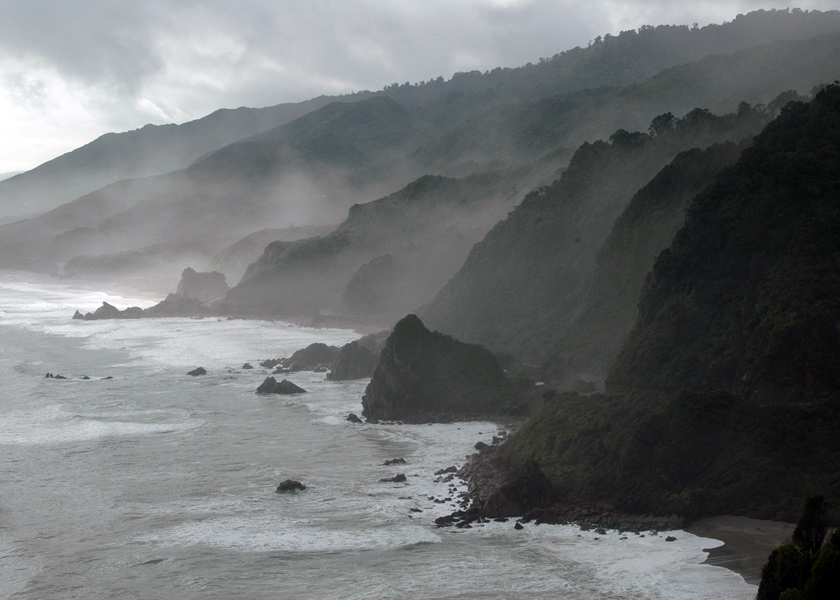

In [126]:
img_path = f"{DATA_RAW_PATH}/New_Zealand_Coast.jpg"
img_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

print("Image shape (H, W, C): ", img_rgb.shape)
print("Image data type: ", img_rgb.dtype)

Image(filename=img_path)


#### Addition or Brightness
The first operation is simple addition of images. This results in increasing or decreasing the brightness of the image since we are eventually increasing or decreasing the intensity values of each pixel by the same amount. So, this will result in a global increase/decrease in brightness.

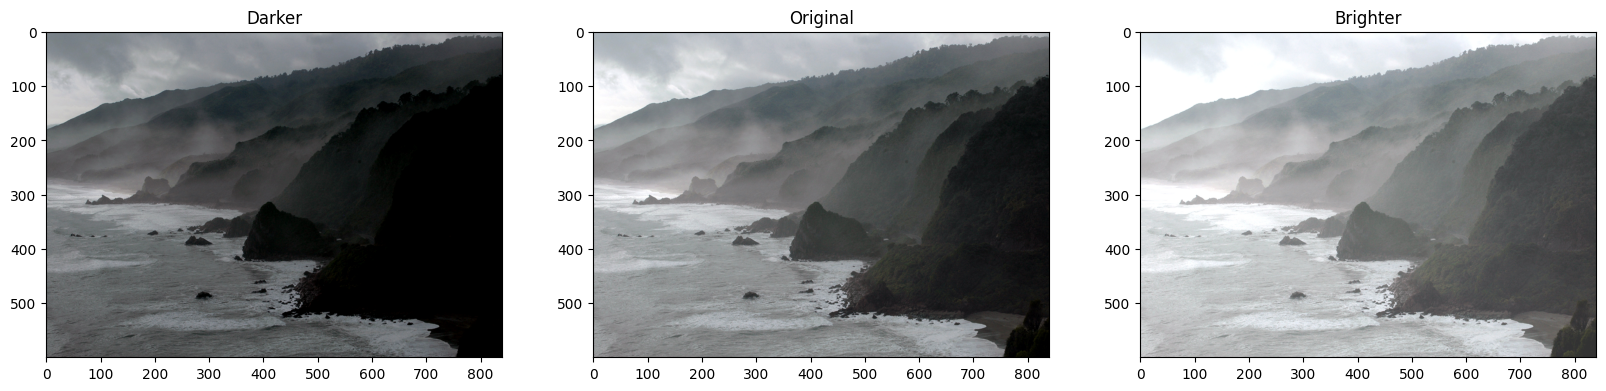

In [127]:
matrix = np.ones(img_rgb.shape, dtype="uint8") * 50

# Adds 50 to every pixel channel value -> Red: R + 50, Green: G + 50, Blue: B + 50
img_brighter = cv2.add(img_rgb, matrix)
# Substract 50 from very pixel channel value -> ...
img_darker = cv2.subtract(img_rgb, matrix)

image_map = {
    "Darker": img_darker,
    "Original": img_rgb,
    "Brighter": img_brighter
}


display_plots(image_map, figsize=[20,5], ncols=3)

#### Why cv2.add/cv2.subtract and not + or -? with numpy array directly?
Using NumPy’s + or - directly on uint8, it wraps around instead of clipping:

import numpy as np
np.array([250], dtype="uint8") + 10  # → 4  (wrong! wraps at 255)
- 250 + 10 = 260
- uint8 can only store 0–255
- it wraps: 260 - 256 = 4

#### Multiplication or Contrast
Just like addition can result in brightness change, multiplication can be used to improve the contrast of the image.

Contrast is the difference in the intensity values of the pixels of an image. Multiplying the intensity values with a constant can make the difference larger or smaller ( if multiplying factor is < 1 ).

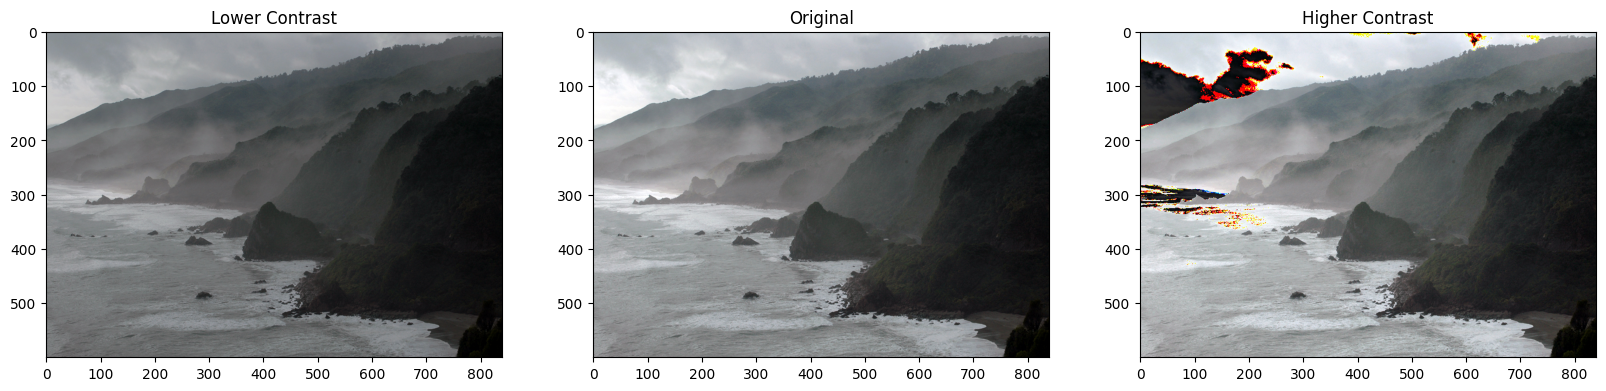

In [128]:
# np.ones() defalut data type is float64
matrix1 = np.ones(img_rgb.shape) * 0.8
matrix2 = np.ones(img_rgb.shape) * 1.2 

# Convert image to float64 to safely multiply 
img_float = np.float64(img_rgb)

# Multiply each pixel by the scale matrix (element-wise)
# Both operands must be the same type: float64
img_rgb_darker   = np.uint8(cv2.multiply(img_float, matrix1))  
img_rgb_brighter = np.uint8(cv2.multiply(img_float, matrix2))  

image_map = {
    "Lower Contrast": img_rgb_darker,
    "Original": img_rgb,
    "Higher Contrast": img_rgb_brighter
}

display_plots(image_map, figsize=[20,5], ncols=3)

#### What happened?
Can you see the weird colors in some areas of the image after multiplication?

The issue is that after multiplying, the values which are already high, are becoming greater than 255. Thus, the overflow issue. So after the overflow it wraps to the smaller value, that's why some white parts of the original image became black and other weird color.

#### numpy.clip() in Python

**numpy.clip()** function is used to Clip (limit) the values in an array. Given an interval, values outside the interval are clipped to the interval edges. For example, if an interval of [0, 1] is specified, values smaller than 0 become 0, and values larger than 1 become 1.

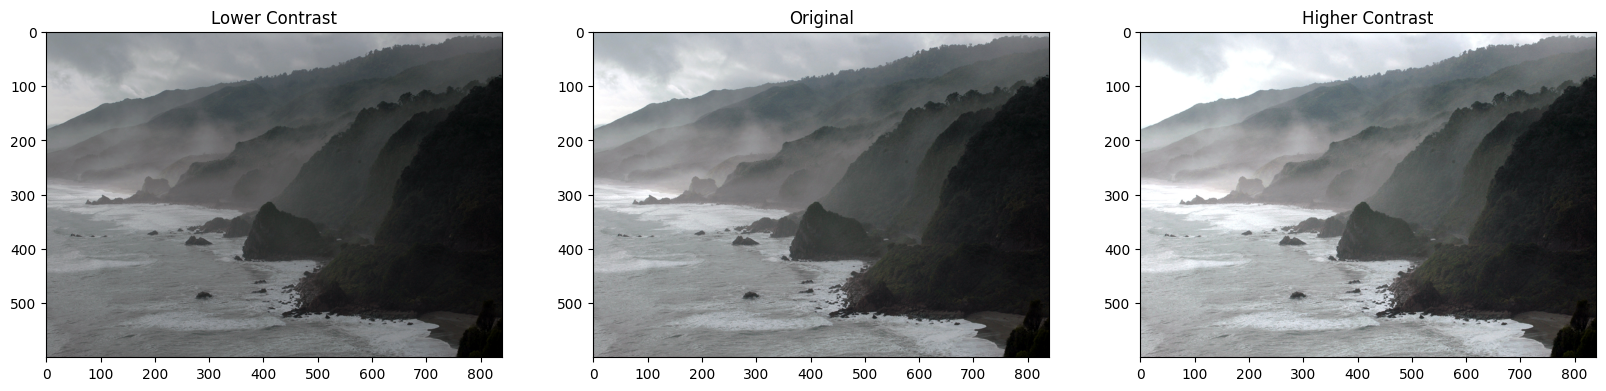

In [129]:
matrix1 = np.ones(img_rgb.shape) * 0.8
matrix2 = np.ones(img_rgb.shape) * 1.2 

img_float = np.float64(img_rgb)

img_rgb_darker   = np.uint8(cv2.multiply(img_float, matrix1))  
img_rgb_brighter = np.uint8(np.clip(cv2.multiply(img_float, matrix2), min=0,max=255))

image_map = {
    "Lower Contrast": img_rgb_darker,
    "Original": img_rgb,
    "Higher Contrast": img_rgb_brighter
}

display_plots(image_map, figsize=[20,5], ncols=3)

#### Image Thresholding
Binary Images have a lot of use cases in Image Processing. One of the most common use cases is that of creating masks. Image Masks allow us to process on specific parts of an image keeping the other parts intact. Image Thresholding is used to create Binary Images from grayscale images. You can use different thresholds to create different binary images from the same original image.

##### <font color="green">Function Syntax </font>

``` python
retval, dst = cv2.threshold( src, thresh, maxval, type[, dst] )
```

`dst`: The output array of the same size and type and the same number of channels as `src`.

The function has **4 required arguments**:

1. `src`: input array (multiple-channel, 8-bit or 32-bit floating point).

2. `thresh`: threshold value.

3. `maxval`: maximum value to use with the THRESH_BINARY and THRESH_BINARY_INV thresholding types.

4. `type`: thresholding type (see ThresholdTypes).


##### <font color="green">Function Syntax </font>

``` python
dst = cv.adaptiveThreshold( src, maxValue, adaptiveMethod, thresholdType, blockSize, C[, dst] )
```

`dst`	Destination image of the same size and the same type as src.

The function has **6 required arguments**:
1. `src`:	Source 8-bit single-channel image.

2. `maxValue`:	Non-zero value assigned to the pixels for which the condition is satisfied

3. `adaptiveMethod`:	Adaptive thresholding algorithm to use, see AdaptiveThresholdTypes. The BORDER_REPLICATE | BORDER_ISOLATED is used to process boundaries.

4. `thresholdType:`	Thresholding type that must be either THRESH_BINARY or THRESH_BINARY_INV, see ThresholdTypes.

5. `blockSize`:	Size of a pixel neighborhood that is used to calculate a threshold value for the pixel: 3, 5, 7, and so on.

6. `C`:	Constant subtracted from the mean or weighted mean (see the details below). Normally, it is positive but may be zero or negative as well.

### <font style="color:rgb(8,133,37)">OpenCV Documentation</font>

<a href="https://docs.opencv.org/4.5.1/d7/d1b/group__imgproc__misc.html#gae8a4a146d1ca78c626a53577199e9c57
https://docs.opencv.org/4.5.1/d7/d4d/tutorial_py_thresholding.html" target="_blank">Documentation link</a>

1.  **cv2.threshold() - Global Thresholding**

- Applies a fixed threshold value to the entire image.
- Best used when lighting across the image is uniform.
- Example: cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
  - All pixels >127 become 255, rest become 0.

2.  **cv2.adaptiveThreshold() - Adaptive Thresholding**

- Calculates a local threshold for each small region (block) of the image.
- Useful when lighting is uneven (e.g., shadows, gradients).
- Two adaptive methods:
  - cv2.ADAPTIVE_THRESH_MEAN_C: mean of block minus constant C
  - cv2.ADAPTIVE_THRESH_GAUSSIAN_C: weighted sum using Gaussian window
- Requires setting:
  - blockSize: size of local area (must be odd, like 11, 15, etc.)
  - C: constant subtracted from the mean or Gaussian result
- Example:
  cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
  cv2.THRESH_BINARY, 11, 2)
  - Computes a threshold for each pixel based on its neighborhood
    and produces a better result under varying lighting conditions.


##### THRESHOLDING TYPES IN OPENCV (Used with cv2.threshold)

1.  **cv2.THRESH_BINARY**

    - If pixel value > threshold: set to maxval (e.g., 255)
    - Else: set to 0
    - Useful for producing a clear black-and-white image

2.  **cv2.THRESH_BINARY_INV**

    - Inverse of THRESH_BINARY
    - If pixel value > threshold: set to 0
    - Else: set to maxval
    - Useful for highlighting dark features on light backgrounds

3.  **cv2.THRESH_TRUNC**

    - If pixel value > threshold: set to the threshold value
    - Else: keep the original pixel value
    - Useful for capping pixel intensities above a limit

4.  **cv2.THRESH_TOZERO**

    - If pixel value > threshold: keep the original value
    - Else: set to 0
    - Keeps only the brighter parts of the image

5.  **cv2.THRESH_TOZERO_INV**
    - If pixel value > threshold: set to 0
    - Else: keep the original value
    - Keeps only the darker parts of the image

##### NOTE:

- These types are used as the 4th parameter in cv2.threshold()
- Only cv2.THRESH_BINARY and cv2.THRESH_BINARY_INV can be used
  in cv2.adaptiveThreshold()


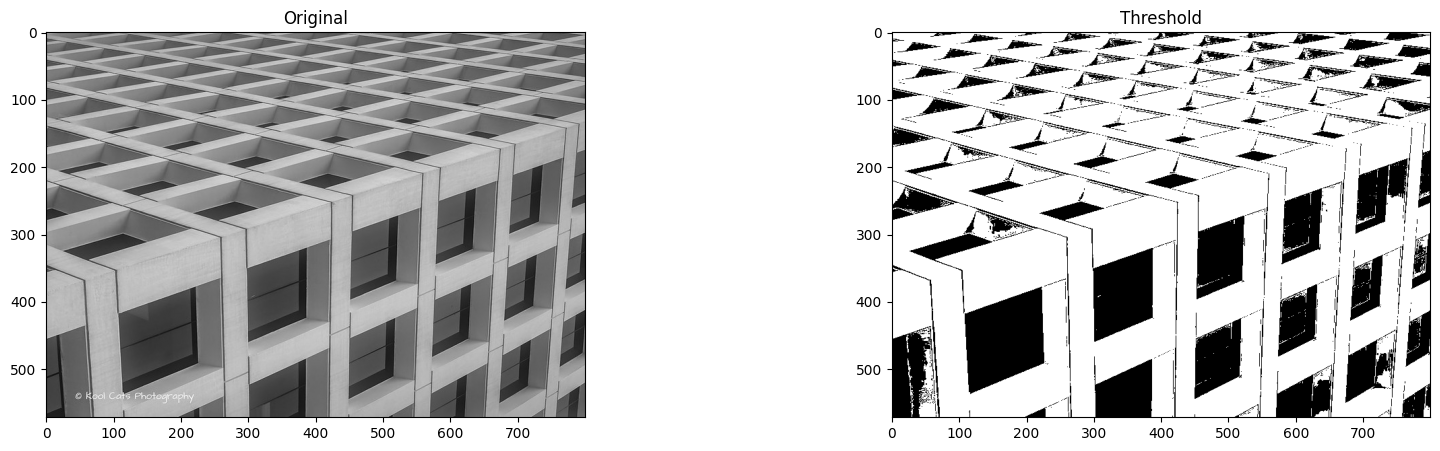

In [130]:
building_img_path = f"{DATA_RAW_PATH}/building-windows.jpg"
img_building_gry = cv2.imread(building_img_path, cv2.IMREAD_GRAYSCALE)

retval, img_thresh = cv2.threshold(img_building_gry, 100, 255, cv2.THRESH_BINARY)

image_map = {
    "Original": img_building_gry,
    "Threshold": img_thresh
}

display_plots(image_map, figsize=[20,5], ncols=2, cmap="gray")

#### Application: Sheet Music Reader
Suppose you wanted to build an application that could read (decode) sheet music. This is similar to
Optical Character Recognigition (OCR) for text documents where the goal is to recognize text characters. In either application, one of the first steps in the processing pipeline is to isolate the important information in the image of a document (separating it from the background). This task can be accomplished with thresholding
techniques. Let's take a look at an example.

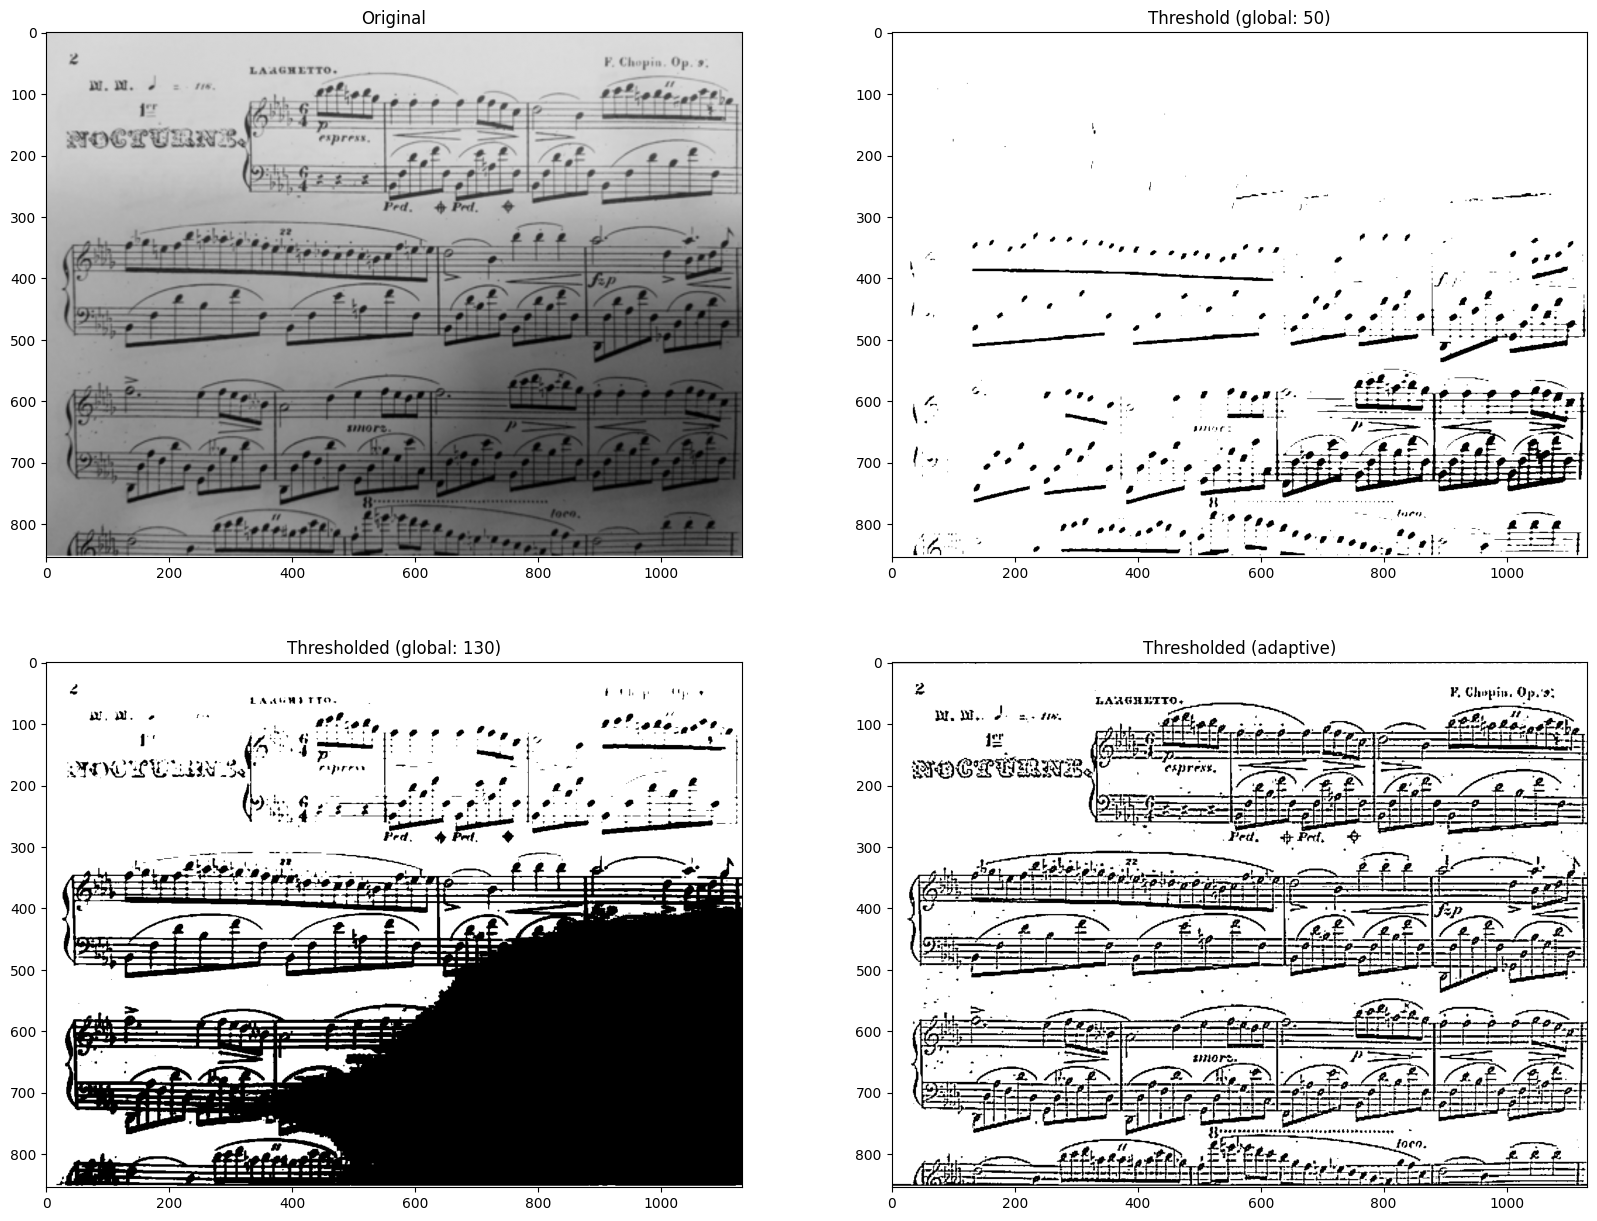

In [131]:
sheet_music_img_path = f"{DATA_RAW_PATH}/Piano_Sheet_Music.png"
img_music_gry = cv2.imread(sheet_music_img_path, cv2.IMREAD_GRAYSCALE)

_, imt_music_gry_threshold_50 = cv2.threshold(img_music_gry, 50, 255, cv2.THRESH_BINARY)
_, imt_music_gry_threshold_130 = cv2.threshold(img_music_gry, 130, 255, cv2.THRESH_BINARY)

img_music_gry_thresh_adap = cv2.adaptiveThreshold(img_music_gry, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 5, 3)

image_map = {
    "Original": img_music_gry,
    "Threshold (global: 50)": imt_music_gry_threshold_50,
    "Thresholded (global: 130)": imt_music_gry_threshold_130,
    "Thresholded (adaptive)": img_music_gry_thresh_adap
}

display_plots(image_map, figsize=[20, 15], indx=2, ncols=2, cmap="gray")

#### Bitwise Operations

##### <font style="color:rgb(8,133,37)">Function Syntax</font>

Example API for `cv2.bitwise_and()`. Others include: `cv2.bitwise_or()`, `cv2.bitwise_xor()`, `cv2.bitwise_not()`

``` python
dst = cv2.bitwise_and( src1, src2[, dst[, mask]] )
```

`dst`: Output array that has the same size and type as the input arrays.

The function has **2 required arguments**:

1. `src1`:	first input array or a scalar.

2. `src2`:	second input array or a scalar.

An important optional argument is:

1. `mask`:	optional operation mask, 8-bit single channel array, that specifies elements of the output array to be changed.


##### <font style="color:rgb(8,133,37)">OpenCV Documentation</font>

1. <a href="https://docs.opencv.org/4.5.1/d0/d86/tutorial_py_image_arithmetics.html" target="_blank">Arithmetic Operations on Images</a>

2. <a href="https://docs.opencv.org/4.5.0/d2/de8/group__core__array.html#ga60b4d04b251ba5eb1392c34425497e14" target="_blank">bitwise_and(...) function</a>

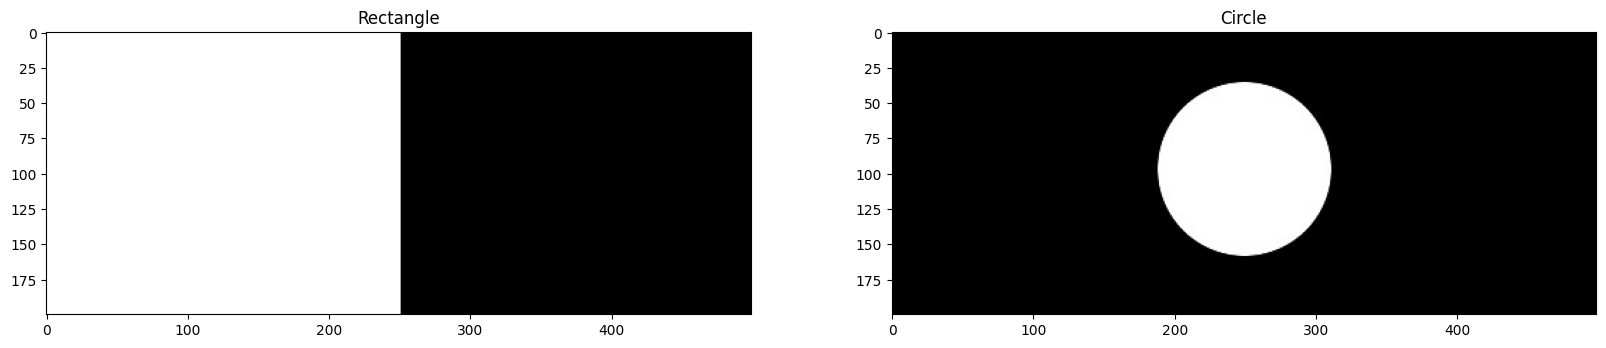

In [132]:
img_rec_path = f"{DATA_RAW_PATH}/rectangle.jpg"
img_cir_path = f"{DATA_RAW_PATH}/circle.jpg"

img_rec_gry = cv2.imread(img_rec_path, cv2.IMREAD_GRAYSCALE)
img_cir_gry = cv2.imread(img_cir_path, cv2.IMREAD_GRAYSCALE)

image_map = {
    "Rectangle": img_rec_gry,
    "Circle": img_cir_gry,
}

display_plots(image_map, figsize=[20, 5], indx=1, ncols=2, cmap="gray")

##### <font color="green">Bitwise AND Operator </font>

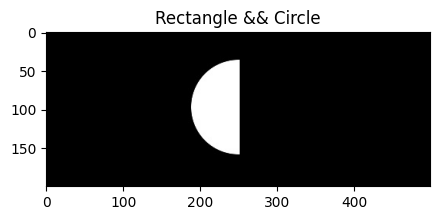

In [133]:
img_rec_cir_and = cv2.bitwise_and(img_rec_gry, img_cir_gry)

image_map = {
    "Rectangle && Circle": img_rec_cir_and,
}

display_plots(image_map, figsize=[20, 2], indx=1, ncols=1, cmap="gray")

##### <font color="green">Bitwise OR Operator </font>

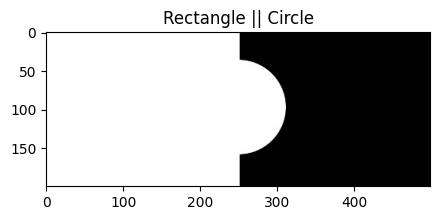

In [134]:
img_rec_cir_or = cv2.bitwise_or(img_rec_gry, img_cir_gry)

image_map = {
    "Rectangle || Circle": img_rec_cir_or,
}

display_plots(image_map, figsize=[20, 2], indx=1, ncols=1, cmap="gray")

##### <font color="green">Bitwise XOR Operator </font>

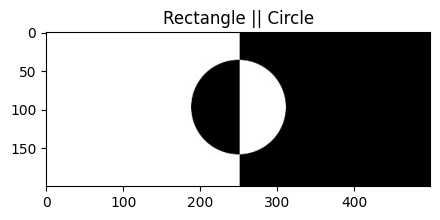

In [135]:
img_rec_cir_xor = cv2.bitwise_xor(img_rec_gry, img_cir_gry)

image_map = {
    "Rectangle || Circle": img_rec_cir_xor,
}

display_plots(image_map, figsize=[20, 2], indx=1, ncols=1, cmap="gray")

#### Application: Logo Manipulation

In this section we will learn to fill in the white lettering of the Coca-Cola logo below with a background image.

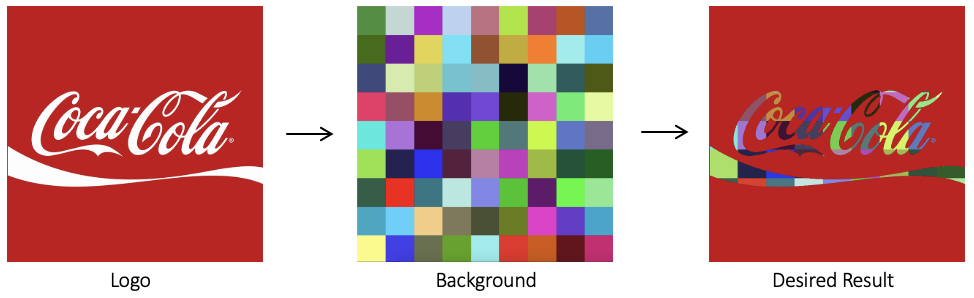

In [136]:
Image(filename=f"{DATA_RAW_PATH}/Logo_Manipulation.png")

##### <font color="green">Read Foreground image</font>

(700, 700, 3)


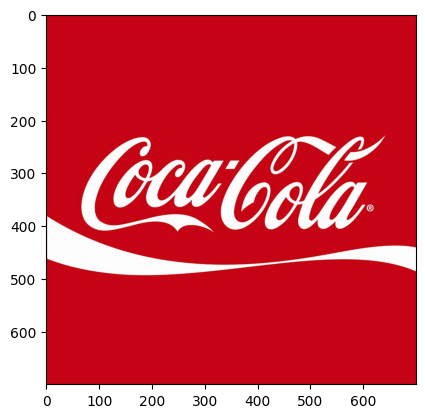

In [137]:
cola_img_path = f"{DATA_RAW_PATH}/coca-cola-logo.png"
img_cola_rgb = cv2.cvtColor(cv2.imread(cola_img_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

print(img_cola_rgb.shape)

cola_w = img_cola_rgb.shape[1]
cola_h = img_cola_rgb.shape[0]

plt.imshow(img_cola_rgb)

#### <font color="green">Read Background image</font>

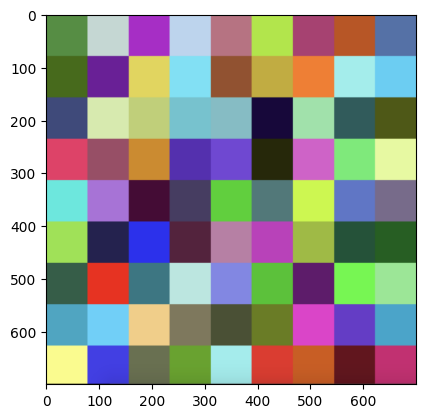

In [138]:
img_background_rgb = cv2.cvtColor(cv2.imread(f"{DATA_RAW_PATH}/checkerboard_color.png", cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
plt.imshow(img_background_rgb)

# Setting desired width (logo_w) and maintaining image aspect ratio
aspect_ratio = cola_w / img_background_rgb.shape[1]
background_h = int(aspect_ratio * img_background_rgb.shape[0])

dim = (cola_w, background_h)

# Resizing background image to size as logo image
img_background_rgb = cv2.resize(img_background_rgb, dim, interpolation=cv2.INTER_AREA)
plt.imshow(img_background_rgb)

##### <font color="green">Create Mask for original Image</font>

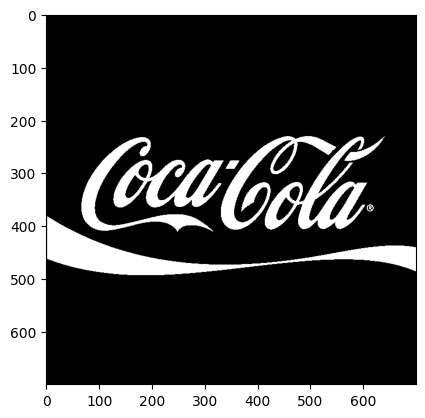

In [139]:
img_cola_gry = cv2.cvtColor(img_cola_rgb, cv2.COLOR_RGB2GRAY)

retval, img_mask = cv2.threshold(img_cola_gry, 127, 255, cv2.THRESH_BINARY)

plt.imshow(img_mask, cmap="gray")

##### <font color="green">Invert the Mask </font>

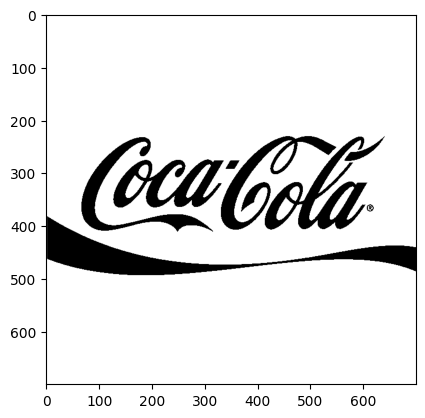

In [140]:
img_cola_thresh_invert = cv2.bitwise_not(img_mask)
plt.imshow(img_cola_thresh_invert, cmap="gray")

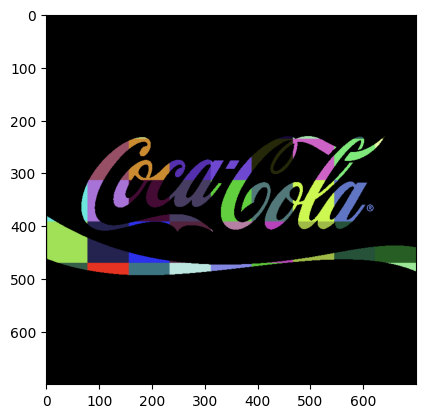

In [141]:
img_background_masked = cv2.bitwise_and(img_background_rgb, img_background_rgb, mask=img_mask)
plt.imshow(img_background_masked)

##### <font color="green">Isolate foreground from image</font>

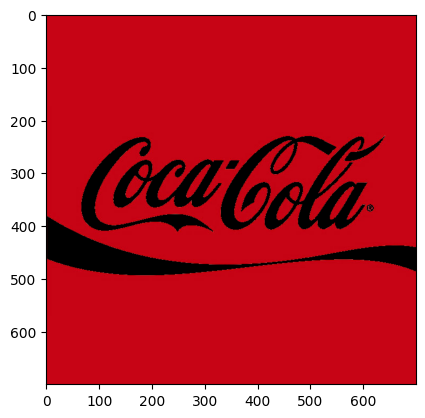

In [142]:
img_foreground = cv2.bitwise_and(img_cola_rgb, img_cola_rgb, mask=img_cola_thresh_invert)
plt.imshow(img_foreground)

##### <font color="green">Result: Merge Foreground and Background</font>

True

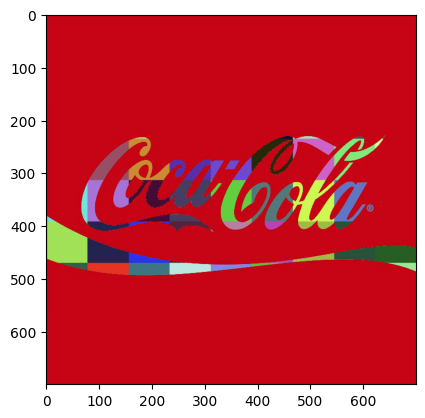

In [143]:
# Add the two previous results obtain the final result

result = cv2.add(img_background_masked, img_foreground)
plt.imshow(result)
cv2.imwrite(f"{DATA_OUTPUT_PATH}/logo_final.png", result[:, :, ::-1])